In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install face_recognition torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using ca

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import os
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import face_recognition
import time

In [ ]:
#Model with feature visualization

from torch import nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)   #ResNext model
        self.model = nn.Sequential(*list(model.children())[: -2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        return fmap, self.dp(self.linear1(x_lstm[:, -1, :]))

In [ ]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize =  transforms.Normalize(mean=-1 * np.divide(mean, std), 
                                      std=np.divide([1, 1, 1], std))

def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy().transpose(1, 2, 0).clip(0, 1)
    cv2.imwrite('./2.png', image * 255)
    return image

def predict(model, img):
    sm = nn.Softmax()
    fmap, logits = model(img.to('cuda'))
    weight_softmax = model.linear1.weight.detach().cpu().numpy()
    logits = sm.(logits)
    _,prediction = torch.max(logits, 1)
    confidence = logits[:, int(prediction.item())].item() * 100
    print('Confidence of prediction:', logits[:, int(prediction.item())].item() * 100)
    
    idx = np.argmax(logits.detach().cpu().numpy())
    _, nc, h, w = fmap.shape
    out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T, weight_softmax[idx, :].T)
    
    predict = out.reshape(h, w)
    predict = predict - np.min(predict)
    predict_img = predict / np.max(predict)
    predict_img = np.uint8(255 * predict_img)
    
    out = cv2.resize(predict_img, (im_size, im_size))
    heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
    img = im_convert(img[:, -1, :, :, :])
    
    result = heatmap * 0.5 + img * 0.8 * 255
    
    cv2.imwrite('/content/1.png', result)
    result = heatmap * 0.5 / 255 + img * 0.8
    result = cv2.merge((cv2.split(result)))
    
    plt.imshow(result)
    plt.show()
    return [int(prediction.item()), confidence]


#img = train_data[100][0].unsqueeze(0)
#predict(model,img)

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition


class validation_dataset(Dataset):
    def __init__(self, video_names, sequence_length=60, transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        # a = int(100/self.count)
        # first_frame = np.random.randint(0, a)

        for _, frame in enumerate(self.frame_extract(video_path)):
            # if(i % a == first_frame):
            faces = face_recognition.face_locations(frame)
            try:
                top, right, bottom, left = faces[0]
                frame = frame[top:bottom, left:right, :]

            except: pass

            frames.append(self.transform(frame))
            if(len(frames) == self.count): break

        #print("no of frames",len(frames))
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)

    def frame_extract(self,path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success: yield image

def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    b, g, r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image * [0.22803, 0.22145, 0.216989] + [0.43216, 0.394666, 0.37645]
    image = image * 255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
!ls -la ./drive/MyDrive/FAKE_videos

total 1439
-rw------- 1 root root 182643 Dec 31  1979 id61_id5_0006.mp4
-rw------- 1 root root 217115 Dec 31  1979 id61_id5_0009.mp4
-rw------- 1 root root 176479 Dec 31  1979 id61_id59_0006.mp4
-rw------- 1 root root 181879 Dec 31  1979 id61_id60_0000.mp4
-rw------- 1 root root 173897 Dec 31  1979 id61_id60_0002.mp4
-rw------- 1 root root 165598 Dec 31  1979 id61_id60_0005.mp4
-rw------- 1 root root 172148 Dec 31  1979 id61_id60_0006.mp4
-rw------- 1 root root 201229 Dec 31  1979 id61_id60_0009.mp4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/content/drive/MyDrive/REAL_videos/zxacihctqp.mp4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


confidence of prediction: 99.99990463256836


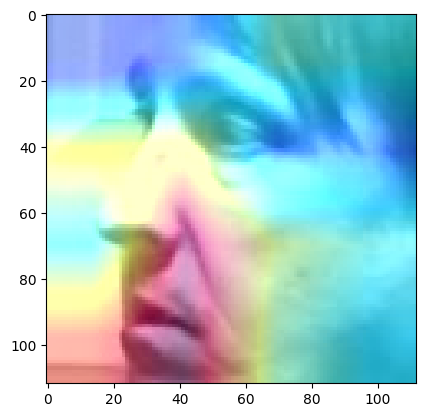

REAL


In [ ]:
#Code for making prediction
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                      transforms.ToPILImage(),
                      transforms.Resize((im_size, im_size)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean, std)])

# path_to_videos = ['/content/drive/My Drive/Balanced_Face_only_data/aagfhgtpmv.mp4',
#                   '/content/drive/My Drive/Balanced_Face_only_data/aczrgyricp.mp4',
#                   '/content/drive/My Drive/Balanced_Face_only_data/agdkmztvby.mp4',
#                   '/content/drive/My Drive/Balanced_Face_only_data/abarnvbtwb.mp4']

# path_to_videos = ['/content/drive/My Drive/Youtube_Face_only_data/000_003.mp4',
#                   '/content/drive/My Drive/Youtube_Face_only_data/000.mp4',
#                   '/content/drive/My Drive/Youtube_Face_only_data/002_006.mp4',
#                   '/content/drive/My Drive/Youtube_Face_only_data/002.mp4']

path_to_videos= ["/content/drive/MyDrive/REAL_videos/zxacihctqp.mp4"]

video_dataset = validation_dataset(path_to_videos,
                                   sequence_length=20,
                                   transform=train_transforms)


path_to_model = '/content/drive/MyDrive/PretrainModel/model_90_acc_60_frames_final_data.pt'
model = Model(2).cuda()
model.load_state_dict(torch.load(path_to_model))
model.eval()


for i in range(0, len(path_to_videos)):
    print(path_to_videos[i])
    prediction = predict(model, video_dataset[i], './')

    print("REAL") if prediction[0] == 1 else print("FAKE")